In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

#PDFs in BDT and sindec?
import os

# set env flags to catch BLAS used for scipy/numpy 
# to only use 1 cpu, n_cpus will be totally controlled by csky
if False:
    os.environ['MKL_NUM_THREADS'] = "1"
    os.environ['NUMEXPR_NUM_THREADS'] = "1"
    os.environ['OMP_NUM_THREADS'] = "1"
    os.environ['OPENBLAS_NUM_THREADS'] = "1"
    os.environ['VECLIB_MAXIMUM_THREADS'] = "1"

import matplotlib as mpl
mpl.rcParams['figure.facecolor'] = 'w'
mpl.rcParams['savefig.facecolor'] = 'w'
import matplotlib.pyplot as plt
from matplotlib import colors, cm
import csky as cy
from csky import cext
import numpy as np
import astropy
#from icecube import astro
import histlite as hl
import healpy
import healpy as hp
import socket
import pickle
import copy
healpy.disable_warnings()
plt.rc('figure', facecolor = 'w')
plt.rc('figure', dpi=100)

## Define Settings

In [2]:
selection_version = 'version-001-p00'

host_name = socket.gethostname()

if 'cobalt' in host_name:
    print('Working on Cobalts')
    data_prefix = '/data/user/ssclafani/data/cscd/final'
    ana_dir = '/data/user/ssclafani/data/analyses/'
    plot_dir = cy.utils.ensure_dir('/home/ssclafani/public_html/DNNC/paperplots/Fig1')
    
else:
    raise ValueError('Unknown host:', host_name)

Working on Cobalts


In [3]:
for dir_path in [plot_dir]:
    if not os.path.exists(dir_path):
        print('Creating directory:', dir_path)
        os.makedirs(dir_path)

## Load Data

In [4]:
repo = cy.selections.Repository()
specs = cy.selections.DNNCascadeDataSpecs.DNNC_10yr

In [5]:
%%time

ana = cy.get_analysis(
    repo, selection_version, specs, 
    #gammas=np.r_[0.1:6.01:0.125],
)

Setting up Analysis for:
DNNCascade_10yr
Setting up DNNCascade_10yr...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/MC_NuGen_bfrv1_2153x.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2011_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2012_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2013_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2014_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2015_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2016_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2017_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2018_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2019_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/IC86_2020_exp.npy ...
Reading /data/ana/analyses/dnn_cascades/version-001-p00/GRL/IC86

In [6]:
a = ana.anas[0]
a.sig

Events(398873 items | columns: azimuth, dec, energy, event, log10energy, mjd, ra, run, sigma, sindec, subevent, xdec, xra, true_dec, true_energy, true_ra, oneweight)

In [7]:
a.bg_data

Events(59610 items | columns: azimuth, dec, energy, event, log10energy, mjd, ra, run, sigma, sindec, subevent)

## Helpers

In [8]:
from cycler import cycle
from copy import deepcopy

soft_colors = cy.plotting.soft_colors
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']


def get_bias_allt(tr, ntrials=200, n_sigs=np.r_[:101:10], quiet=False):
    trials = [
        (None if quiet else print(f'\r{n_sig:4d} ...', end='', flush=True))
        or
        tr.get_many_fits(ntrials, n_sig=n_sig, logging=False, seed=n_sig)
        for n_sig in n_sigs]
    if not quiet:
        print()
    for (n_sig, t) in zip(n_sigs, trials):
        t['ntrue'] = np.repeat(n_sig, len(t))
    allt = cy.utils.Arrays.concatenate(trials)
    return allt

def get_color_cycler():
    return cycle(colors)

def plot_ns_bias(ax, tr, allt, label=''):

    n_sigs = np.unique(allt.ntrue)
    dns = np.mean(np.diff(n_sigs))
    ns_bins = np.r_[n_sigs - 0.5*dns, n_sigs[-1] + 0.5*dns]
    expect_kw = dict(color='C0', ls='--', lw=1, zorder=-10)

    h = hl.hist((allt.ntrue, allt.ns), bins=(ns_bins, 100))
    hl.plot1d(ax, h.contain_project(1),errorbands=True, 
              drawstyle='default', label=label)
    lim = ns_bins[[0, -1]]
    ax.set_xlim(ax.set_ylim(lim))
    ax.plot(lim, lim, **expect_kw)
    ax.set_aspect('equal')

    ax.set_xlabel(r'$n_{inj}$')
    ax.set_ylabel(r'$n_s$')
    ax.grid()

def plot_gamma_bias(ax, tr, allt, label=''):

    n_sigs = np.unique(allt.ntrue)
    dns = np.mean(np.diff(n_sigs))
    ns_bins = np.r_[n_sigs - 0.5*dns, n_sigs[-1] + 0.5*dns]
    expect_kw = dict(color='C0', ls='--', lw=1, zorder=-10)
    expect_gamma = tr.sig_injs[0].flux[0].gamma

    h = hl.hist((allt.ntrue, allt.gamma), bins=(ns_bins, 100))
    hl.plot1d(ax, h.contain_project(1),errorbands=True, 
              drawstyle='default', label=label)
    lim = ns_bins[[0, -1]]
    ax.set_xlim(lim)
    ax.set_ylim(1, 4)
    ax.axhline(expect_gamma, **expect_kw)

    ax.set_xlabel(r'$n_{inj}$')
    ax.set_ylabel(r'$\gamma$')
    ax.grid()

def plot_bkg_trials(
            bg, fig=None, ax=None, 
            label='{} bg trials', 
            label_fit=r'$\chi^2[{:.2f}\mathrm{{dof}},\ \eta={:.3f}]$', 
            color=colors[0],
            density=False,
            bins=50,
        ):
    if ax is None:
        fig, ax = plt.subplots(figsize=(6, 4))
    
    if density:
        h = bg.get_hist(bins=bins).normalize()
    else:
        h = bg.get_hist(bins=bins)
    if label is not None:
        label = label.format(bg.n_total)
    hl.plot1d(ax, h, crosses=True, color=color, label=label)

    # compare with the chi2 fit:
    if hasattr(bg, 'pdf'):
        x = h.centers[0]
        norm = h.integrate().values
        if label_fit is not None:
            label_fit = label_fit.format(bg.ndof, bg.eta)
        if density:
            ax.semilogy(x, bg.pdf(x), lw=1, ls='--', label=label_fit, color=color)
        else:
            ax.semilogy(x, norm * bg.pdf(x), lw=1, ls='--', label=label_fit, color=color)

    ax.set_xlabel(r'TS')
    if density:
        ax.set_ylabel(r'Density')
    else:
        ax.set_ylabel(r'number of trials')
    ax.legend()
        
    return fig, ax

## Setup Analysis

In [9]:
import sys
sys.path.insert(0, '../..')

import config as cg

cg.base_dir = '/data/user/mhuennefeld/data/analyses/unblinding_v1.0.0/'

Running as User: ssclafani on Hostname: cobalt05.icecube.wisc.edu


In [10]:
def get_gp_tr(template_str, cutoff=np.inf, gamma=None, cpus=20):
    cutoff_GeV = cutoff * 1e3
    gp_conf = cg.get_gp_conf(
        template_str=template_str, gamma=gamma, cutoff_GeV=cutoff_GeV, base_dir=cg.base_dir)
    tr = cy.get_trial_runner(gp_conf, ana=ana, mp_cpus=cpus)
    return tr

def get_template_tr(template, gamma=2.7, cutoff_tev=np.inf, cpus=20):
    cutoff_gev = cutoff_tev * 1000.
    gp_conf = {
        'template': template,
        'flux': cy.hyp.PowerLawFlux(gamma, energy_cutoff=cutoff_gev),
        'randomize': ['ra'],
        'fitter_args': dict(gamma=gamma),
        'sigsub': True,
        'update_bg': True,
        'fast_weight': False,
    }
    tr = cy.get_trial_runner(gp_conf, ana=ana, mp_cpus=cpus)
    return tr


#### Get TrialRunners

In [11]:
tr_dict = {
    'pi0': get_gp_tr('pi0'),
    'kra5': get_gp_tr('kra5'),
    'kra50': get_gp_tr('kra50'),
}

Reading /data/ana/analyses/NuSources/2021_DNNCascade_analyses/templates/Fermi-LAT_pi0_map.npy ...
<- /data/user/mhuennefeld/data/analyses/unblinding_v1.0.0//templates/pi0/gamma/2.700/DNNCascade_10yr.template.npy    
Restore successful.
Reading /data/ana/analyses/NuSources/2021_DNNCascade_analyses/templates/KRA-gamma_5PeV_maps_energies.tuple.npy ...
<- /data/user/mhuennefeld/data/analyses/unblinding_v1.0.0//templates/kra5/DNNCascade_10yr.template.npy    
Restore successful.
Reading /data/ana/analyses/NuSources/2021_DNNCascade_analyses/templates/KRA-gamma_maps_energies.tuple.npy ...
<- /data/user/mhuennefeld/data/analyses/unblinding_v1.0.0//templates/kra50/DNNCascade_10yr.template.npy    
Restore successful.


#### Get Results for each template

In [12]:
res_dict = {}
for key in tr_dict.keys():
    f_path = os.path.join(
        cg.base_dir, 
        'gp/results/{}/{}_unblinded.npy'.format(key, key), 
    )
    res_dict[key] = np.load(f_path)

#### Print best fit fluxes

In [13]:

dNdE = tr_dict['pi0'].to_dNdE(ns=res_dict['pi0'][1], E0=1e5)
E2dNdE = tr_dict['pi0'].to_E2dNdE(ns=res_dict['pi0'][1], E0=100, unit=1e3)
print(dNdE, E2dNdE)


2.4366279686479028e-18 2.436627968647903e-11


In [15]:
a = ana[0]

In [25]:
tr = tr_dict['pi0']

In [28]:
llh = tr.llh_models[0]

In [39]:
a = llh.acc_model
w = a.get_acc_per_source(gamma = 2.7)

In [75]:
def get_gal_coords(array, nside):
    y = range(len(array))
    theta, phi = hp.pix2ang(128, y)
    ra = phi
    dec = np.pi/2 - theta
    l , b = astro.equa_to_gal(ra,dec)
    return l, b

In [70]:
from icecube import astro

In [77]:
ls, bs  = get_gal_coords(w, 128)

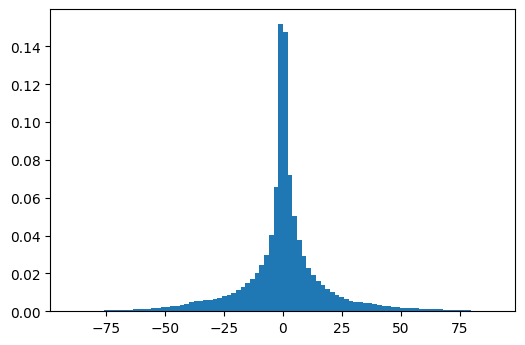

In [88]:
plt.hist(np.degrees(bs), weights=w/sum(w), bins=90, label='pi0 template');


In [86]:
get_gal_coords(, 128)

NameError: name 'd' is not defined